In [1]:
import matplotlib.pyplot as plt
import numpy as np

from reconsnet.model.diffusion import DiffusionModule
from reconsnet.data.dataset import ClinicalDataset
from reconsnet.config import set_config_path
from reconsnet.util.coords import reproject
from reconsnet.data.postprocess import percentile_threshold, denoise_voxels
from pathlib import Path
from tqdm import tqdm

CHECKPOINT_PATH = "/home/shared/model-weights/both.ckpt"
DATA_PATH = "/home/shared/uck-right"
RESULTS_PATH = "data/synthetic_right.csv"
CAMERA_GRID_SIZE = (60, 60, 60)

In [3]:
set_config_path(Path("../config"))

model = DiffusionModule.load_from_checkpoint(CHECKPOINT_PATH, lr=1e-4)
reconstruct = lambda x: model.fast_reconstruct(*x, num_inference_steps=10, guidance=True)
ds = ClinicalDataset(DATA_PATH)

# General

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.01it/s]


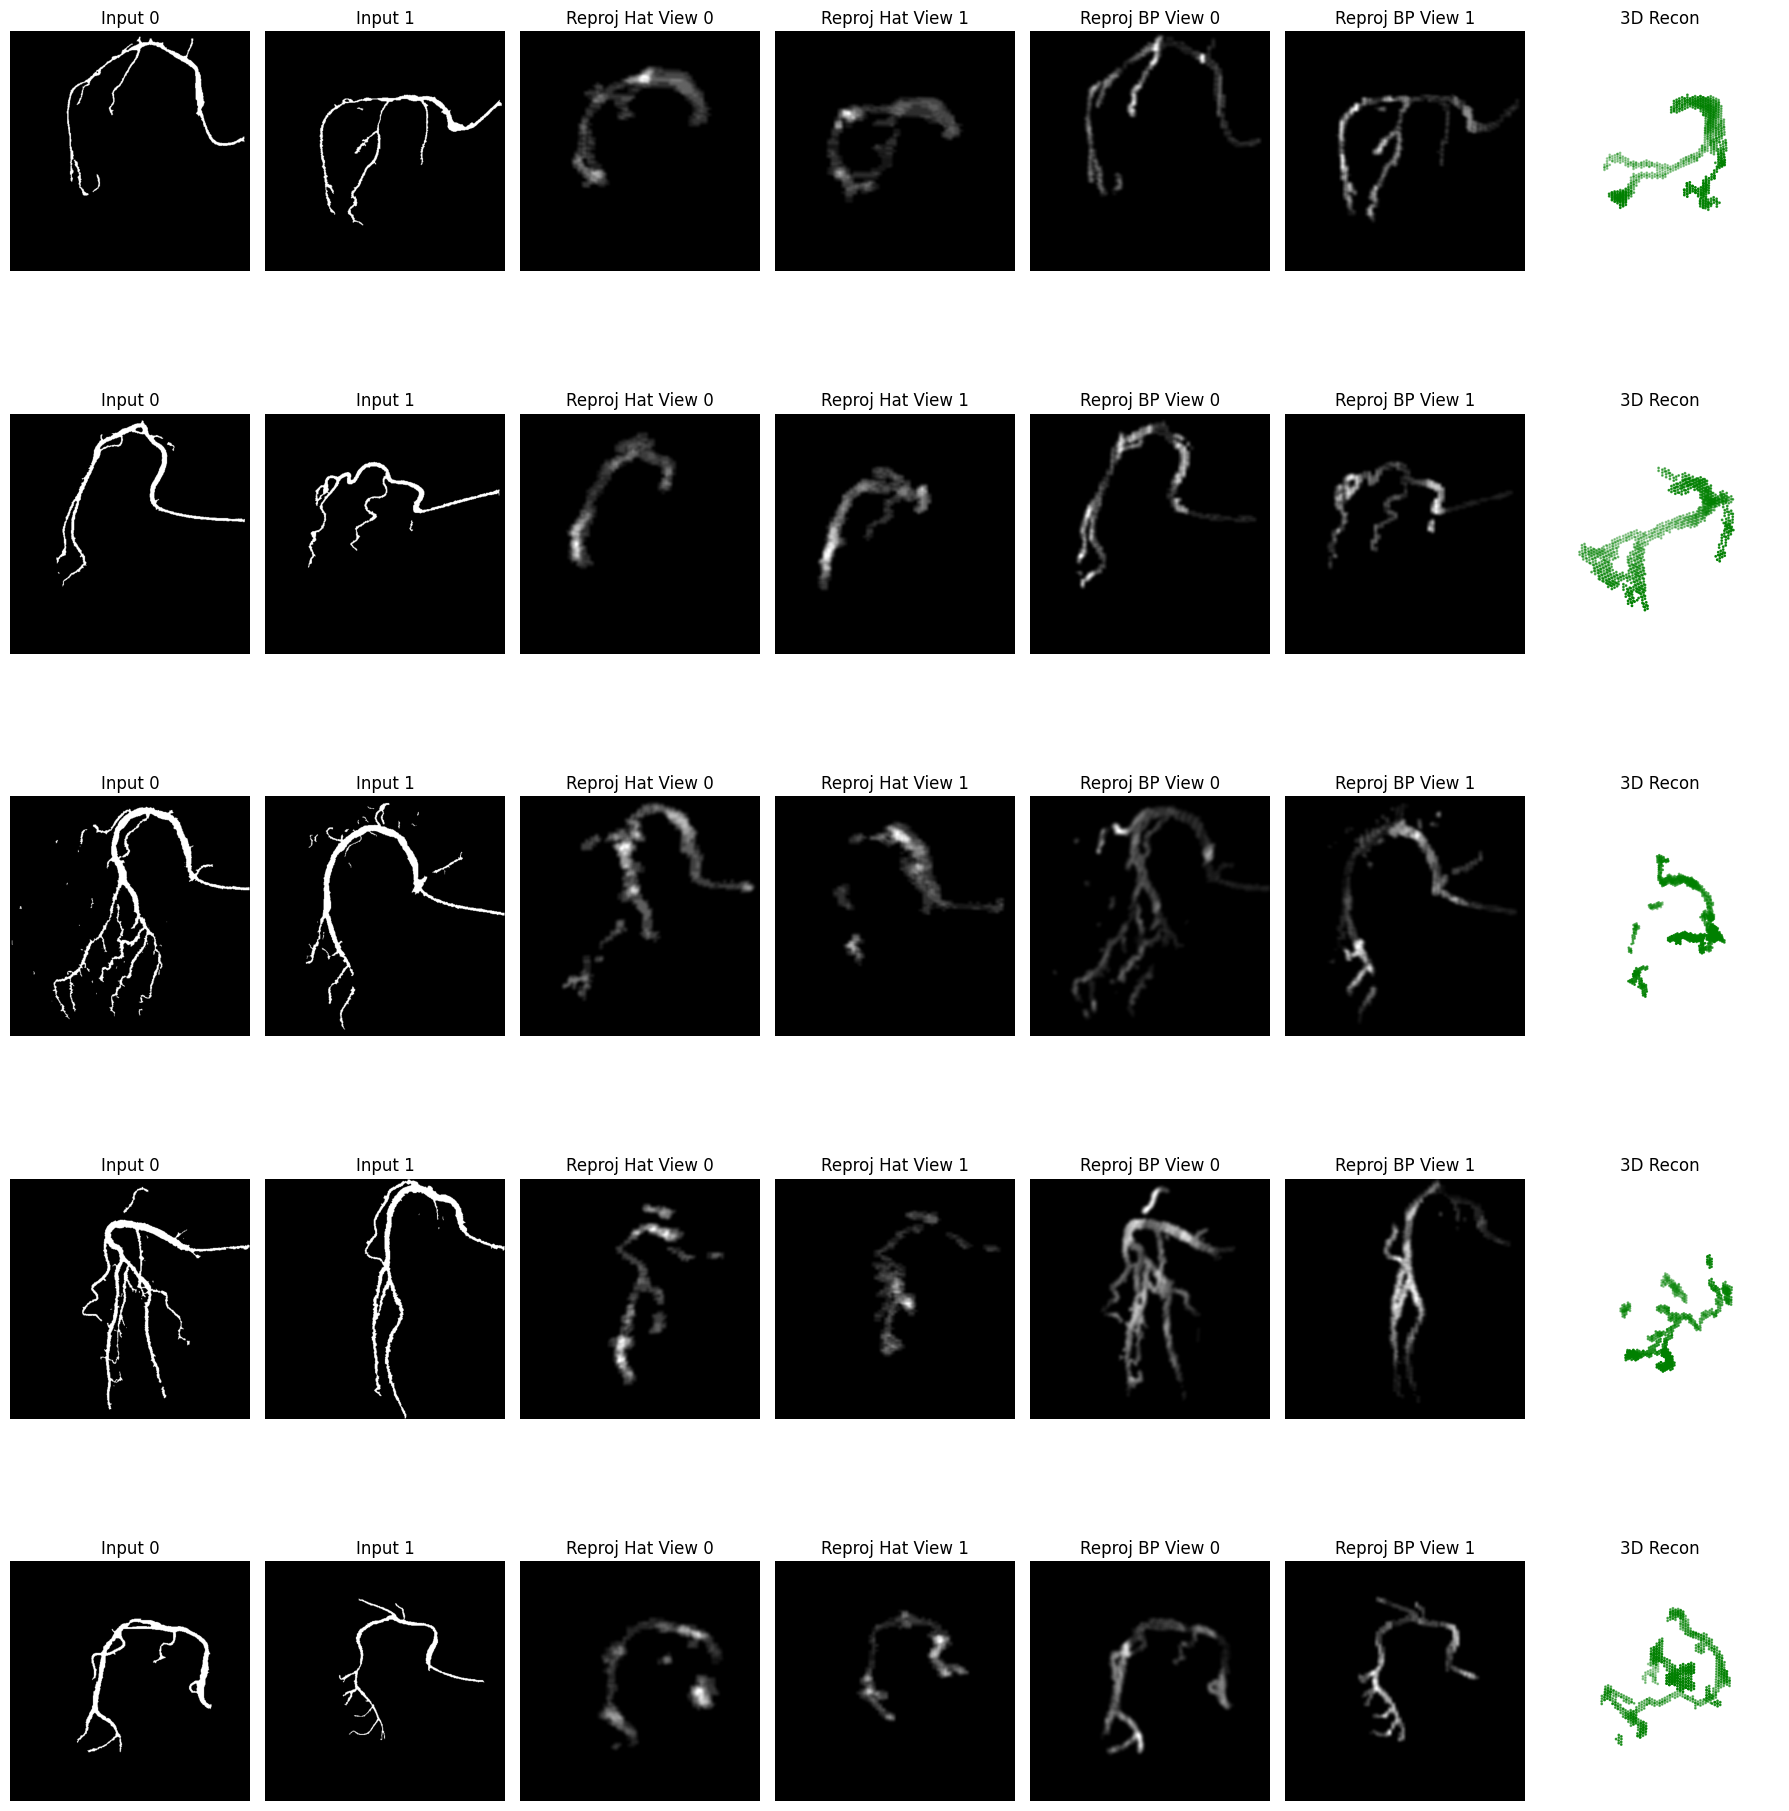

In [9]:
n_samples = 5
fig = plt.figure(figsize=(18, 4 * n_samples))

for i in range(n_samples):
    (backprojection, _, p0, p1), xray0, xray1 = ds[i]
    backprojection = backprojection.to(model.device)
    p0 = p0.to(model.device)
    p1 = p1.to(model.device)

    hat = reconstruct((backprojection.unsqueeze(0), p0.unsqueeze(0).unsqueeze(0), p1.unsqueeze(0).unsqueeze(0)))
    hat = (hat - hat.min()) / (hat.max() - hat.min())

    threshold = percentile_threshold(hat, percentile=0.995)
    hat_bin = (hat > threshold).float().squeeze().cpu().numpy()
    hat_bin = denoise_voxels((hat > threshold).float(), min_neighbors=5).squeeze().cpu().numpy()
    bp_bin = (backprojection > 0).squeeze().cpu().numpy()

    pred0, pred1 = reproject(hat_bin, xray0, xray1, CAMERA_GRID_SIZE)
    backproj0, backproj1 = reproject(bp_bin, xray0, xray1, CAMERA_GRID_SIZE)

    ax0 = fig.add_subplot(n_samples, 7, i*7 + 1)
    ax0.imshow(xray0.img, cmap='gray')
    ax0.set_title("Input 0")
    ax0.axis('off')

    ax1 = fig.add_subplot(n_samples, 7, i*7 + 2)
    ax1.imshow(xray1.img, cmap='gray')
    ax1.set_title("Input 1")
    ax1.axis('off')

    ax2 = fig.add_subplot(n_samples, 7, i*7 + 3)
    ax2.imshow(pred0, cmap='gray')
    ax2.set_title("Reproj Hat View 0")
    ax2.axis('off')

    ax3 = fig.add_subplot(n_samples, 7, i*7 + 4)
    ax3.imshow(pred1, cmap='gray')
    ax3.set_title("Reproj Hat View 1")
    ax3.axis('off')

    ax4 = fig.add_subplot(n_samples, 7, i*7 + 5)
    ax4.imshow(backproj0, cmap='gray')
    ax4.set_title("Reproj BP View 0")
    ax4.axis('off')

    ax5 = fig.add_subplot(n_samples, 7, i*7 + 6)
    ax5.imshow(backproj1, cmap='gray')
    ax5.set_title("Reproj BP View 1")
    ax5.axis('off')

    ax6 = fig.add_subplot(n_samples, 7, i*7 + 7, projection='3d')
    pcd = np.argwhere(hat_bin > 0)
    ax6.scatter(pcd[:, 0], pcd[:, 1], pcd[:, 2], s=1, c='green')
    ax6.set_title("3D Recon")
    ax6.view_init(elev=30, azim=45)
    ax6.axis('off')

    
plt.tight_layout()
plt.show()


In [4]:
def reconstruct_ix(i):
    (backprojection, _, p0, p1), xray0, xray1 = ds[i]
    p0 = p0.to(model.device)
    p1 = p1.to(model.device)
    backprojection = backprojection.to(model.device)
    hat = reconstruct((backprojection.unsqueeze(0), p0.unsqueeze(0).unsqueeze(0), p1.unsqueeze(0).unsqueeze(0)))
    hat = (hat - hat.min()) / (hat.max() - hat.min())

    threshold = percentile_threshold(hat, percentile=0.995)
    hat_bin = (hat > threshold).float().squeeze().cpu().numpy()
    hat_bin = denoise_voxels((hat > threshold).float(), min_neighbors=5).squeeze().cpu().numpy()
    return np.argwhere(hat_bin > 0), xray0.img, xray1.img


# Shape

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.12it/s]


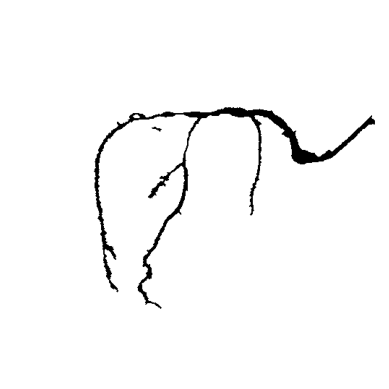

In [21]:
points, xray0, xray1 = reconstruct_ix(0)
x, y, z = points[:, 0], points[:, 1], points[:, 2]


plt.imshow(xray1, cmap='Greys')
plt.axis('off')
plt.show()



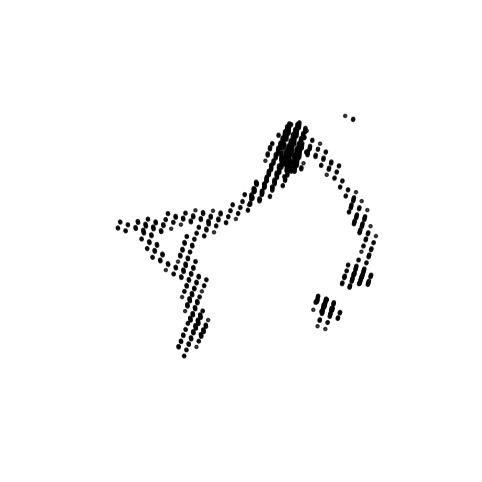

In [26]:
# %matplotlib widget

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, s=5, c='black', alpha=0.7)

ax.view_init(elev=80, azim=20)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.axis('off')

plt.show()

# Stochasticity

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.87it/s]


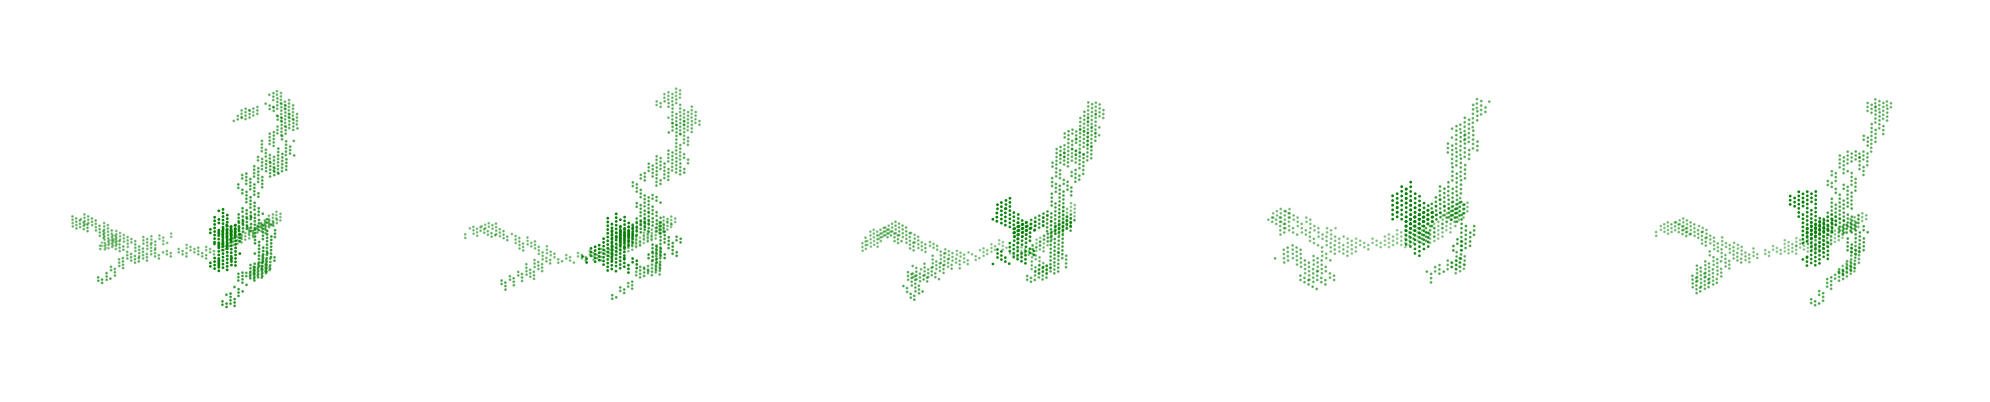

In [29]:
n_samples = 5
fig = plt.figure(figsize=(4 * n_samples, 6))

for i in range(n_samples):
    (backprojection, _, p0, p1), xray0, xray1 = ds[10]
    backprojection = backprojection.to(model.device)
    p0 = p0.to(model.device)
    p1 = p1.to(model.device)

    hat = reconstruct((backprojection.unsqueeze(0),
                       p0.unsqueeze(0).unsqueeze(0),
                       p1.unsqueeze(0).unsqueeze(0)))
    hat = (hat - hat.min()) / (hat.max() - hat.min())

    threshold = percentile_threshold(hat, percentile=0.995)
    hat_bin = (hat > threshold).float().squeeze().cpu().numpy()
    hat_bin = denoise_voxels((hat > threshold).float(), min_neighbors=5).squeeze().cpu().numpy()
    bp_bin = (backprojection > 0).squeeze().cpu().numpy()

    pred0, pred1 = reproject(hat_bin, xray0, xray1, CAMERA_GRID_SIZE)
    backproj0, backproj1 = reproject(bp_bin, xray0, xray1, CAMERA_GRID_SIZE)

    ax = fig.add_subplot(1, n_samples, i + 1, projection='3d')
    pcd = np.argwhere(hat_bin > 0)
    ax.scatter(pcd[:, 0], pcd[:, 1], pcd[:, 2], s=1, c='green')
    ax.view_init(elev=30, azim=45)
    ax.axis('off')

plt.tight_layout()
plt.show()